In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from scipy.integrate import solve_ivp
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
import sys, copy, os
from tqdm.notebook import tqdm 

# hot letters
b, r, s, t, f = "b", "r", "s", "t", "f"

In [2]:
# define the lorenz system
def lorenz(t, y, beta, rho, sigma):
    
    # unpack + assert derivatives
    X, Y, Z = tuple(y)
    return np.array([sigma*(Y-X), X*(rho-Z) - Y, (X*Y)-beta*Z])

In [3]:
# encode our parameter settings
regimes = [("Stable (Transient Chaos)", (5.0, 5.0, 5.0), (8/3, 23.00, 10.0)), 
           ("Chaotic (Butterfly)", (5.0, 5.0, 5.0), (8/3, 28.00, 10.0))]

# generate our trajectories + store them
trajs = {}; TM = 500
for i, regime in enumerate(regimes):

    # unpack the settings
    name, y0, theta = regime
    beta, rho, sigma = theta
    sol = solve_ivp(fun=lorenz, t_span=(0.0, TM), y0=np.array(y0), 
                    t_eval=np.linspace(start=0.0, stop=TM, num=1000001), 
                    args=(beta, rho, sigma), rtol=1e-10, atol=1e-10)
    trajs[rho] = sol

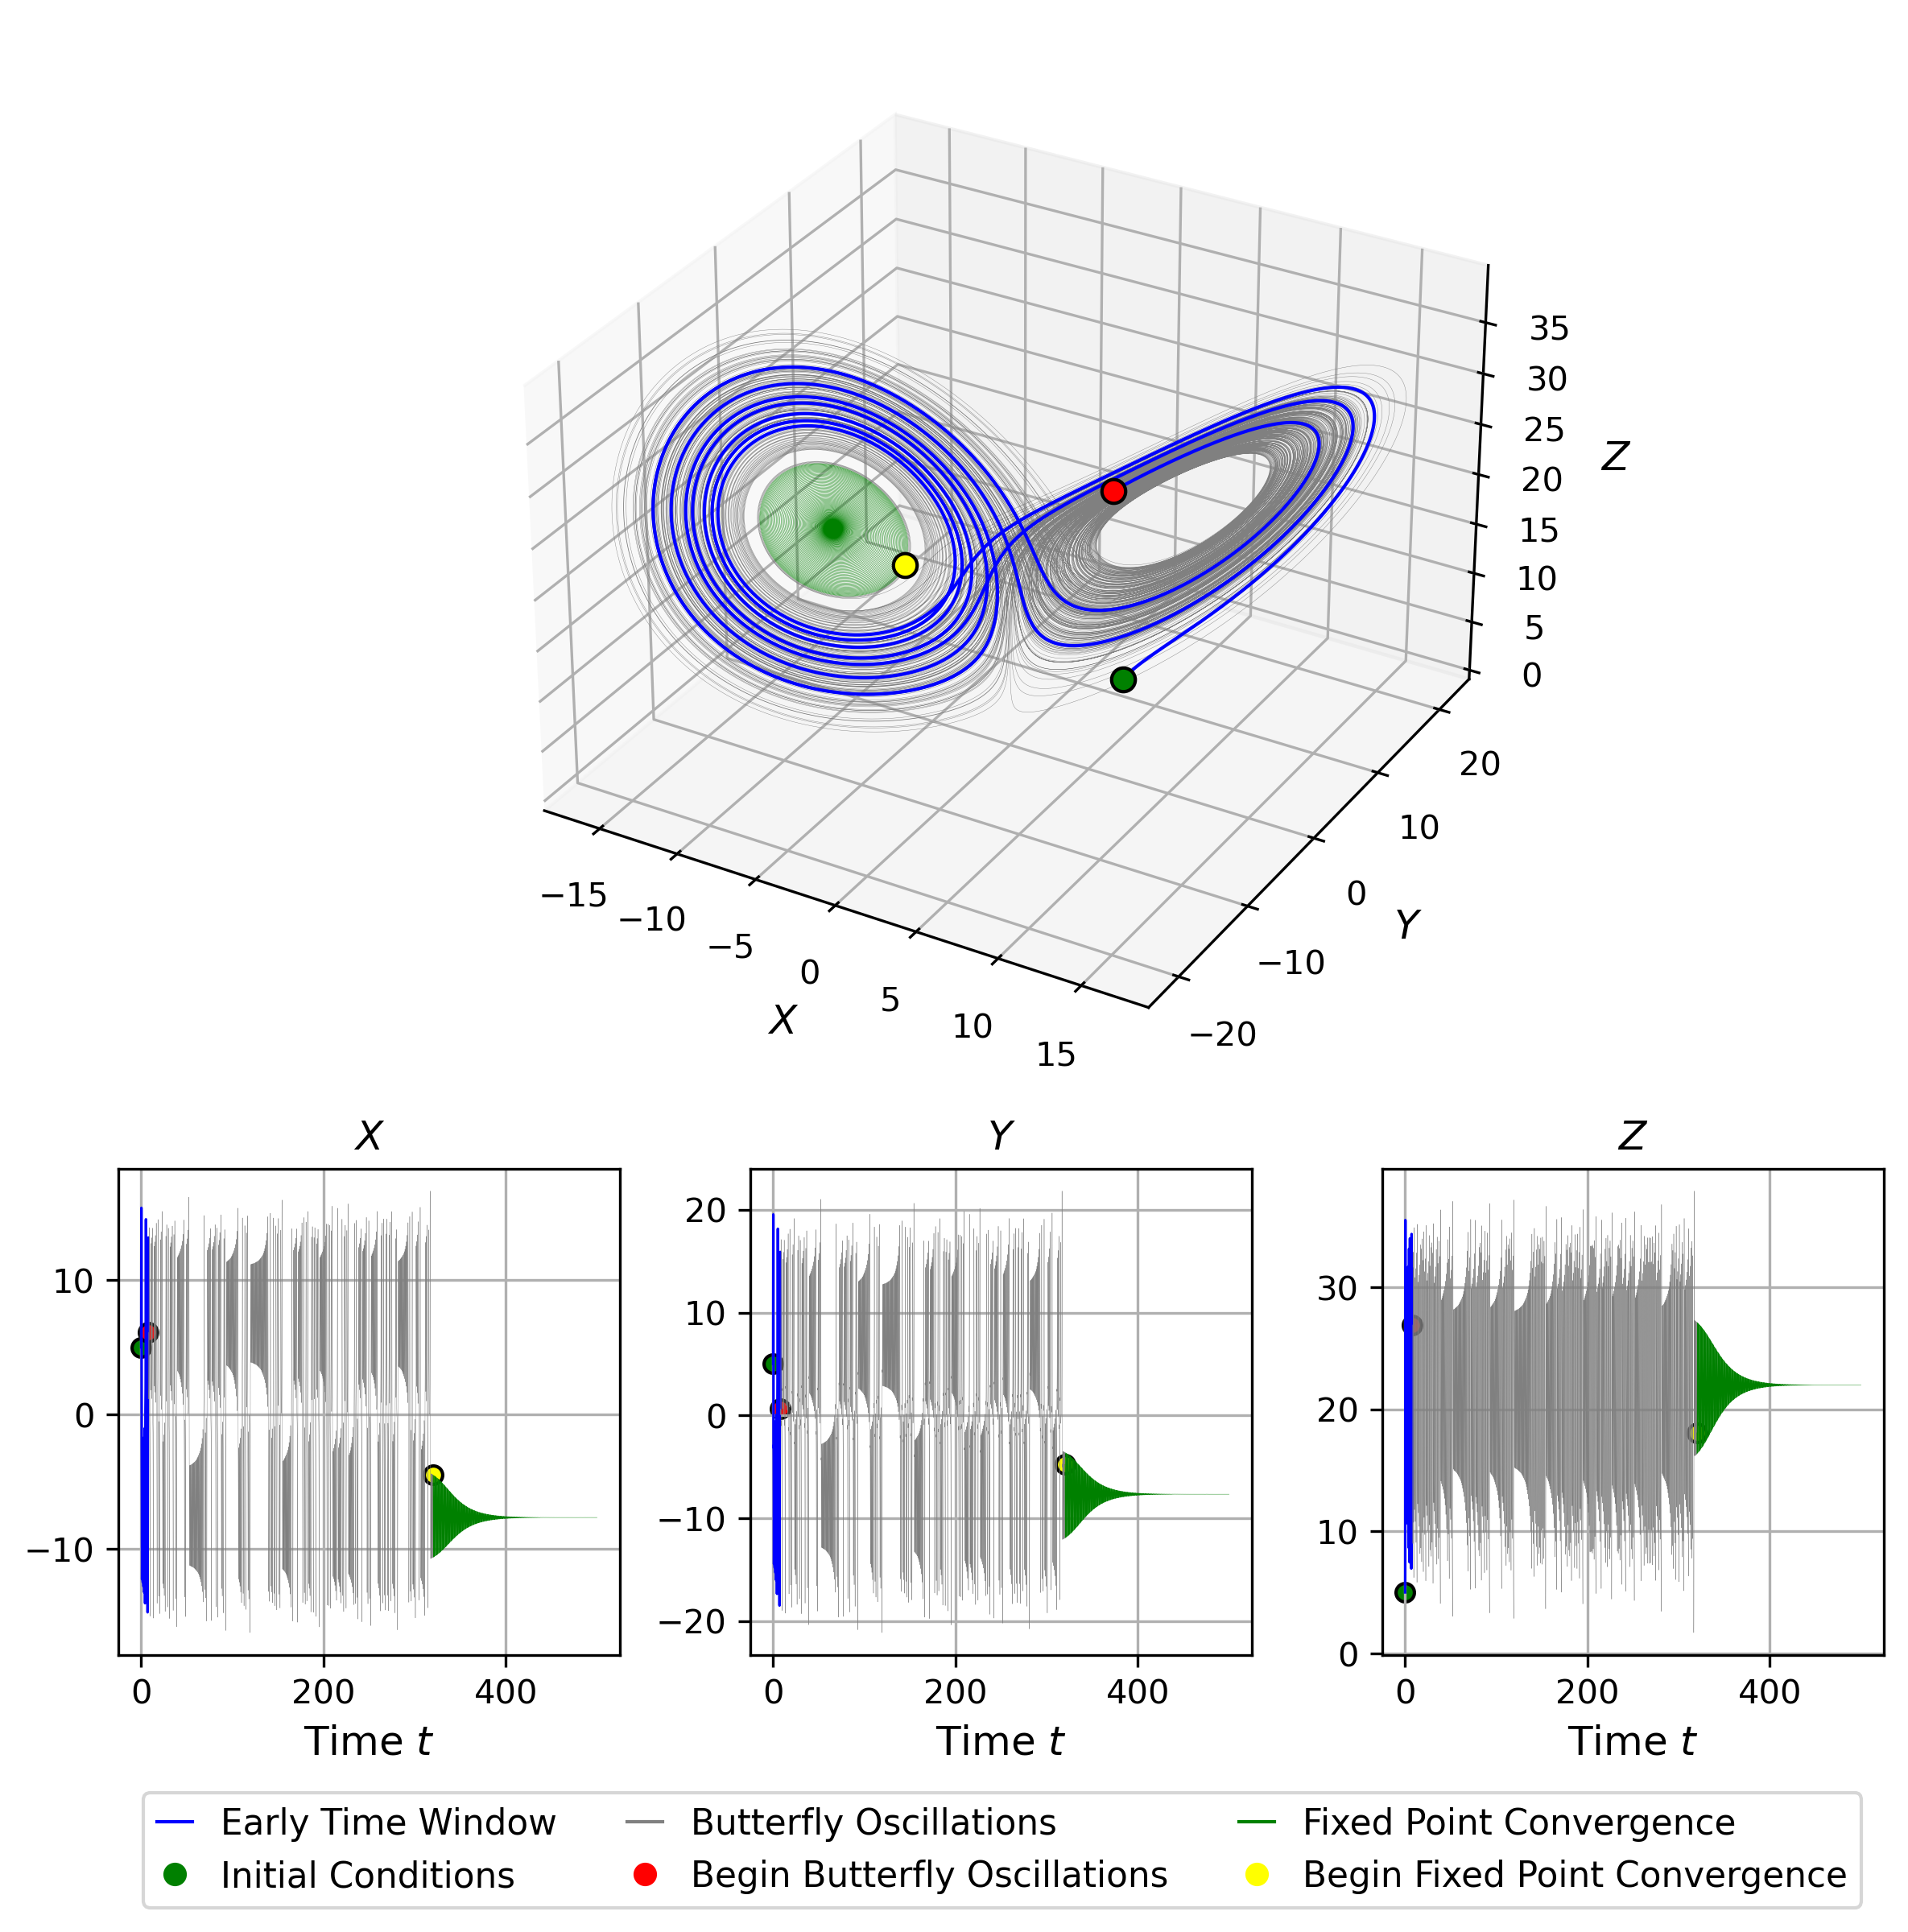

In [4]:
# toggle for our green final convergence cutoff range (original was 320)
final_cutoff = 320

# create a figure for stable (transient chaos) + corresponding grid-spec
fig = plt.figure(figsize=(8, 7.5), dpi=300)
gs = gridspec.GridSpec(12, 3)

# for each component, separate into in-sample, intermediate, and final convergence
for i, comp in enumerate(["$X$", "$Y$", "$Z$"]):
    
    # create our subplot
    ax = fig.add_subplot(gs[8:, i:i+1])
    
    # work on the in-sample (show in blue)
    in_sample = (trajs[23.0].t <= 8.0)
    ax.plot(
        trajs[23.0].t[in_sample], 
        trajs[23.0].y.T[:,i][in_sample],
        color="blue", linewidth=0.75
    )
    
    # intermediate "butterfly"-like oscillations
    intermediate = np.where((trajs[23.0].t > 8.0) & (trajs[23.0].t <= final_cutoff))
    ax.plot(
        trajs[23.0].t[intermediate], 
        trajs[23.0].y.T[:,i][intermediate], 
        color="grey", linewidth=0.1)
    
    # final convergence to fixed-point.
    final = np.where(trajs[23.0].t > final_cutoff)
    ax.plot(
        trajs[23.0].t[final], 
        trajs[23.0].y.T[:,i][final], 
        color="green", linewidth=0.1)

    # mark the points of change
    ax.scatter(
        trajs[23.0].t[in_sample][0], 
        trajs[23.0].y.T[:,i][in_sample][0], 
        color="green", s=30, edgecolor="black")
    ax.scatter(
        trajs[23.0].t[intermediate][0], 
        trajs[23.0].y.T[:,i][intermediate][0], 
        color="red", s=30, edgecolor="black")
    ax.scatter(
        trajs[23.0].t[final][0], 
        trajs[23.0].y.T[:,i][final][0], 
        color="yellow", s=30, edgecolor="black")
    
    # beautify
    ax.grid()
    ax.set_title(comp, fontsize=12)
    ax.set_xlabel("Time $t$", fontsize=12)
    
# create our 3D subplot
ax2 = fig.add_subplot(gs[:8, :], projection="3d")

# intermediate butterfly-type oscillations (mark starting point + tendril traj)
ax2.scatter(
    trajs[23.0].y.T[in_sample, 0][-1], 
    trajs[23.0].y.T[in_sample, 1][-1], 
    trajs[23.0].y.T[in_sample, 2][-1], 
    color="red", s=50, edgecolor="black") 
ax2.plot(
    trajs[23.0].y.T[intermediate, 0][0], 
    trajs[23.0].y.T[intermediate, 1][0], 
    trajs[23.0].y.T[intermediate, 2][0], color="grey", linewidth=0.1)

# end-game convergence to fixed point
ax2.scatter(
    trajs[23.0].y.T[final, 0][0, 0], 
    trajs[23.0].y.T[final, 1][0, 0], 
    trajs[23.0].y.T[final, 2][0, 0], color="yellow", s=50, edgecolor="black")
ax2.plot(
    trajs[23.0].y.T[final, 0][0], 
    trajs[23.0].y.T[final, 1][0], 
    trajs[23.0].y.T[final, 2][0], color="green", linewidth=0.1)

# in-sample observations
ax2.scatter(
    trajs[23.0].y.T[0,0], 
    trajs[23.0].y.T[0,1], 
    trajs[23.0].y.T[0,2], color="green", s=50, edgecolor="black")
ax2.plot(
    trajs[23.0].y.T[in_sample, 0], 
    trajs[23.0].y.T[in_sample, 1], 
    trajs[23.0].y.T[in_sample, 2], color="blue", linewidth=1.0)
ax2.set_xlabel("$X$", fontsize=12)
ax2.set_ylabel("$Y$", fontsize=12)
ax2.set_zlabel("$Z$", fontsize=12)
ax2.set_box_aspect((1, 1, 0.7))
ax2.view_init(elev=30)

# beautify
name, y0, theta = regimes[0]
custom_lines = [
    Line2D([0], [0], color="blue", linewidth=1.0, alpha=1.0, label="Early Time Window"),
    Line2D([0], [0], color="green", marker="o", linestyle="None", label="Initial Conditions"),
    Line2D([0], [0], color="grey", linewidth=1.0, alpha=1.0, label="Butterfly Oscillations"),
    Line2D([0], [0], color="red", marker="o", linestyle="None", label="Begin Butterfly Oscillations"),
    Line2D([0], [0], color="green", linewidth=1.0, alpha=1.0, label="Fixed Point Convergence"),
    Line2D([0], [0], color="yellow", marker="o", linestyle="None", label="Begin Fixed Point Convergence"),
]
fig.legend(handles=custom_lines, handlelength=1.0,
           loc="lower center", ncol=3, fontsize=10.5, bbox_to_anchor=(0.525, -0.07))
plt.tight_layout()
plt.savefig("camera_ready/regimes/stable-transient-chaos.jpg", facecolor="white", bbox_inches="tight")
plt.show()

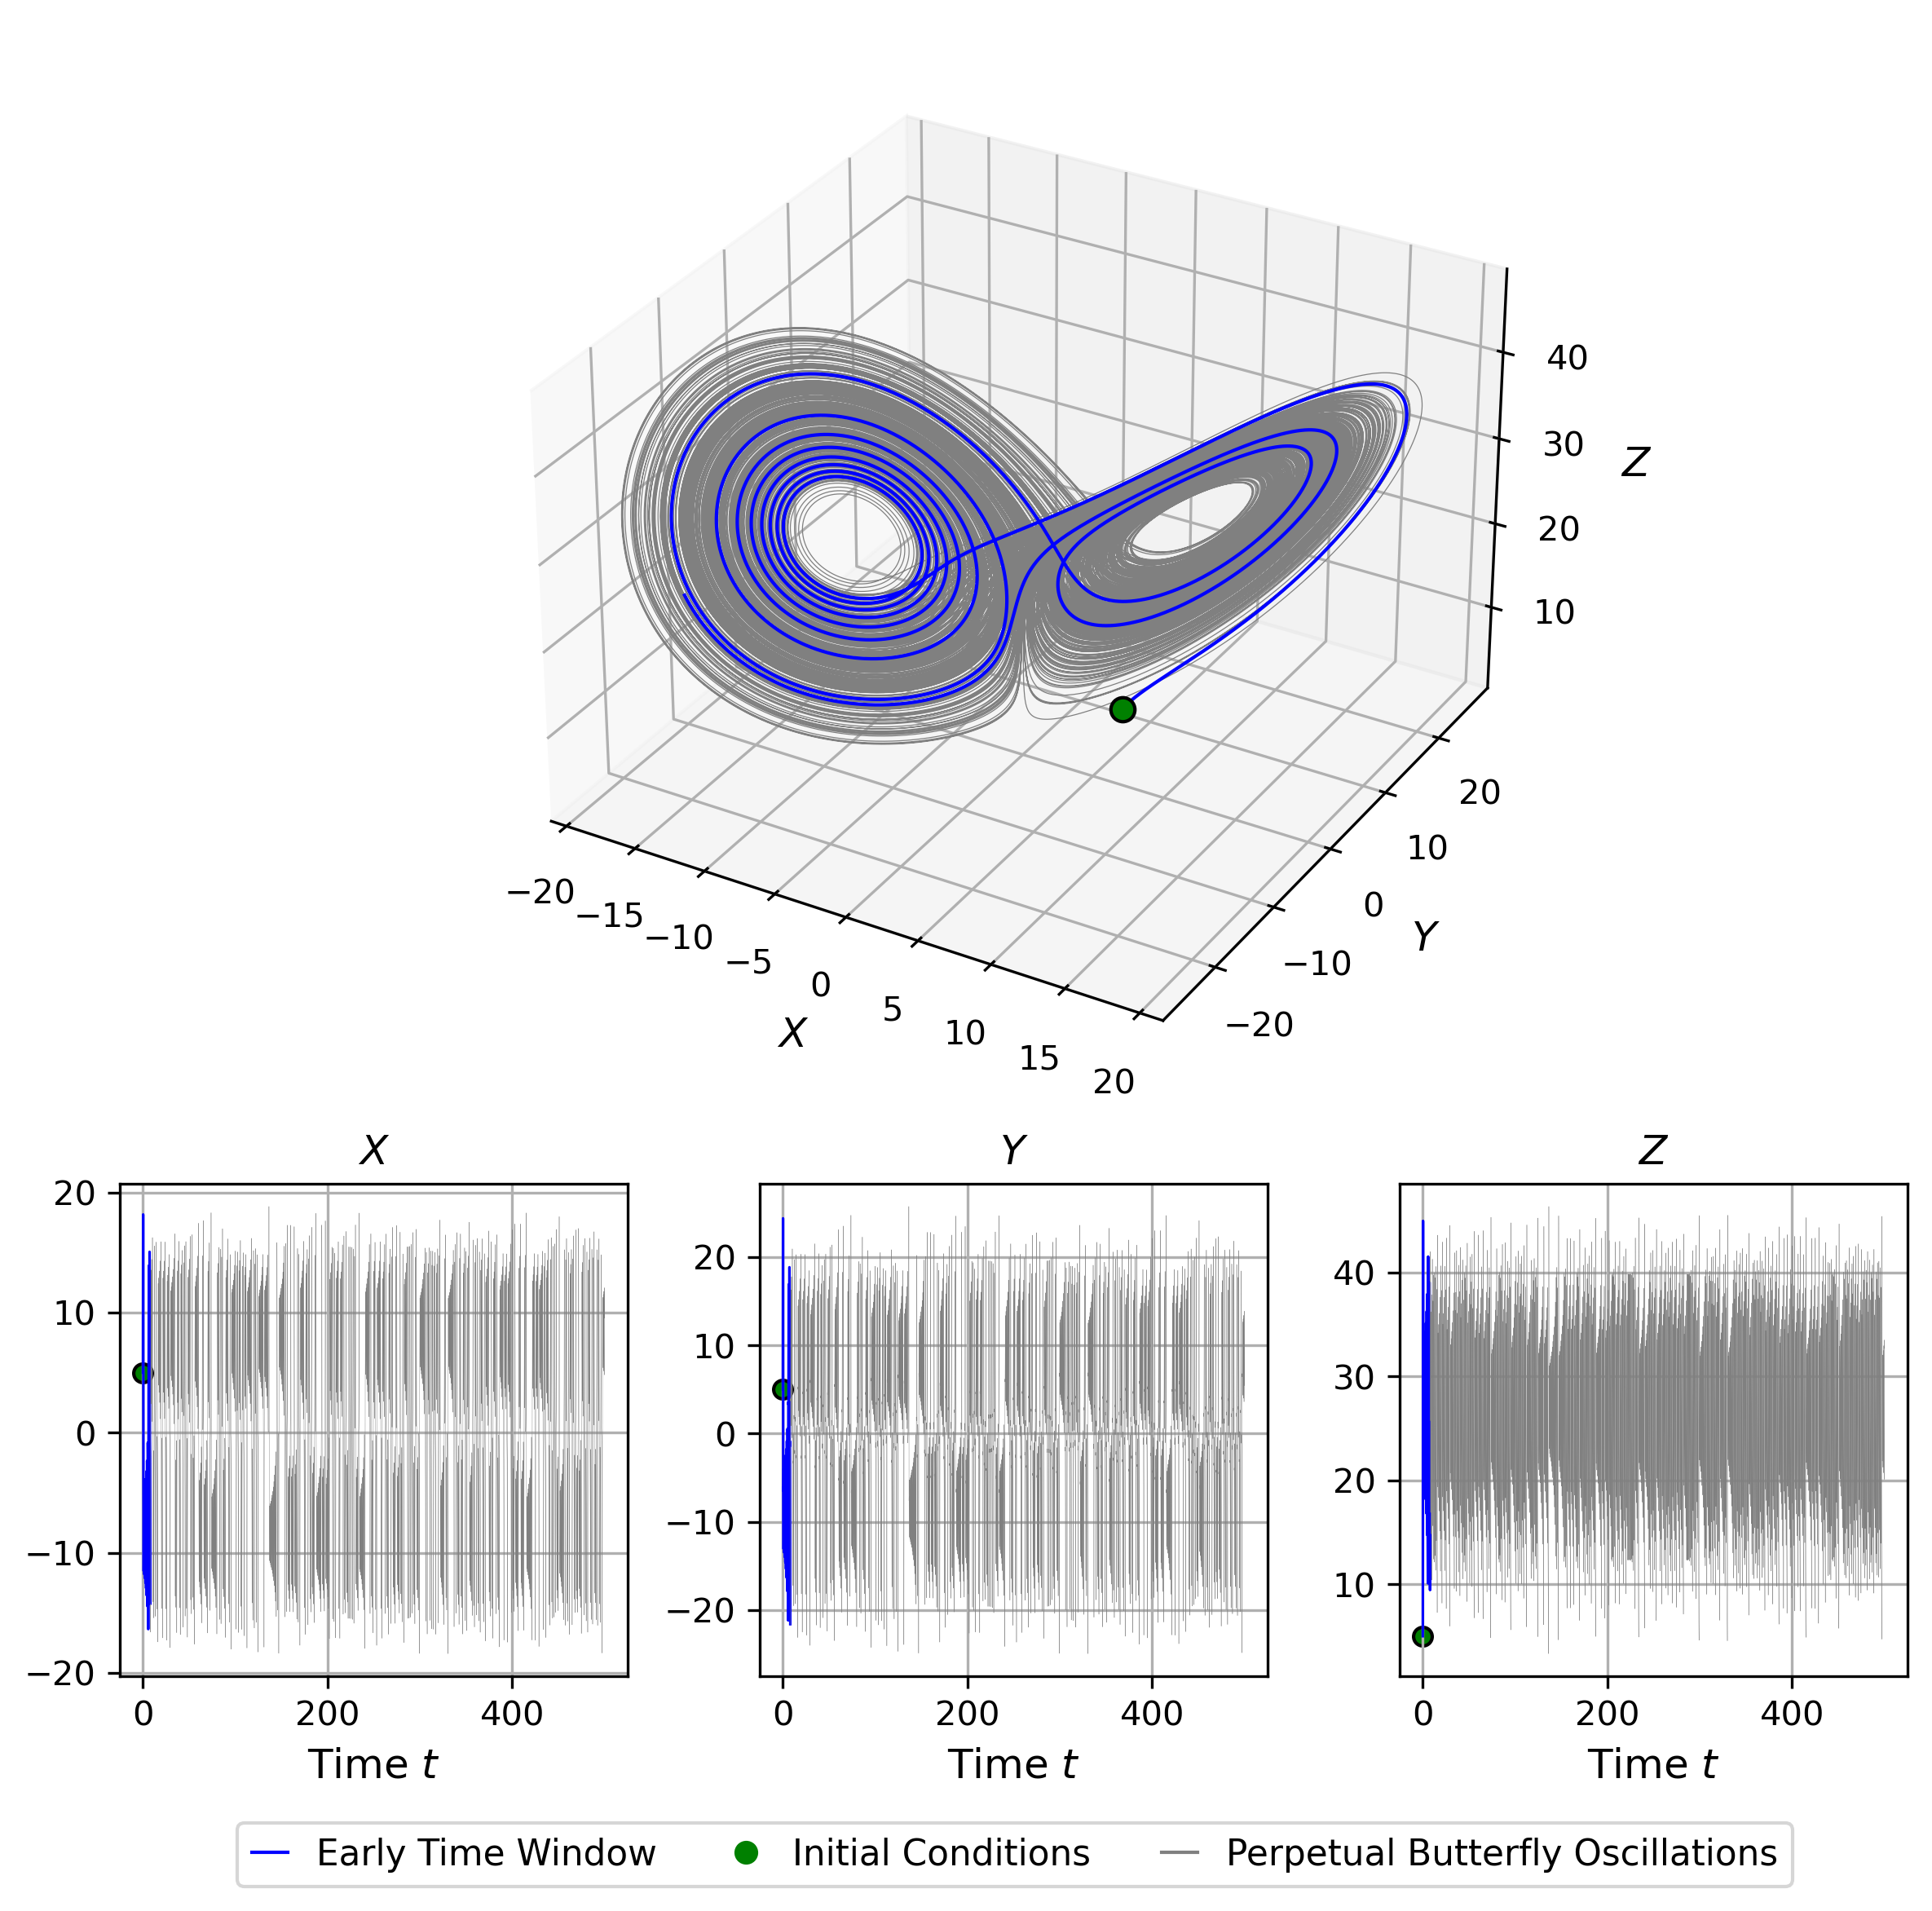

In [5]:
# create a figure for stable (transient chaos) + corresponding grid-spec
fig = plt.figure(figsize=(8, 7.5), dpi=300)
gs = gridspec.GridSpec(12, 3)

# for each component, separate into in-sample, intermediate, and final convergence
for i, comp in enumerate(["$X$", "$Y$", "$Z$"]):
    
    # create our subplot
    ax = fig.add_subplot(gs[8:, i:i+1])
    
    # work on the in-sample (show in blue)
    in_sample = (trajs[28.0].t <= 8.0)
    ax.plot(
        trajs[28.0].t[in_sample], 
        trajs[28.0].y.T[:,i][in_sample],
        color="blue", linewidth=0.75
    )
    
    # final convergence to fixed-point.
    final = np.where(trajs[28.0].t > 8.0)
    ax.plot(
        trajs[28.0].t[final], 
        trajs[28.0].y.T[:,i][final], 
        color="grey", linewidth=0.1)

    # mark the initial conditions
    ax.scatter(
        trajs[28.0].t[in_sample][0], 
        trajs[28.0].y.T[:,i][in_sample][0], 
        color="green", s=30, edgecolor="black")
    
    # beautify
    ax.grid()
    ax.set_title(comp, fontsize=12)
    ax.set_xlabel("Time $t$", fontsize=12)
    
# create our 3D subplot
ax2 = fig.add_subplot(gs[:8, :], projection="3d")

# end-game convergence to fixed point
ax2.plot(
    trajs[28.0].y.T[final, 0][0], 
    trajs[28.0].y.T[final, 1][0], 
    trajs[28.0].y.T[final, 2][0], color="grey", linewidth=0.3)

# in-sample observations
ax2.scatter(
    trajs[28.0].y.T[0,0], 
    trajs[28.0].y.T[0,1], 
    trajs[28.0].y.T[0,2], color="green", s=50, edgecolor="black")
ax2.plot(
    trajs[28.0].y.T[in_sample, 0], 
    trajs[28.0].y.T[in_sample, 1], 
    trajs[28.0].y.T[in_sample, 2], color="blue", linewidth=1.0)
ax2.set_xlabel("$X$", fontsize=12)
ax2.set_ylabel("$Y$", fontsize=12)
ax2.set_zlabel("$Z$", fontsize=12)
ax2.set_box_aspect((1, 1, 0.7))
ax2.view_init(elev=30)

# beautify
name, y0, theta = regimes[1]
custom_lines = [
    Line2D([0], [0], color="blue", linewidth=1.0, alpha=1.0, label="Early Time Window"),
    Line2D([0], [0], color="green", marker="o", linestyle="None", label="Initial Conditions"),
    Line2D([0], [0], color="grey", linewidth=1.0, alpha=1.0, label="Perpetual Butterfly Oscillations"),
]
fig.legend(handles=custom_lines, handlelength=1.0,
           loc="lower center", ncol=3, fontsize=10.5, bbox_to_anchor=(0.525, -0.045))
plt.tight_layout()
plt.savefig("camera_ready/regimes/chaotic-butterfly.jpg", facecolor="white", bbox_inches="tight")
plt.show()